# CUSTOMER CHURN PREDICTION USING MACHINE LEARNING
# Bachelor's Thesis - Telecom Churn Dataset

## 1. Introduction

This notebook implements customer churn prediction for a telecommunications dataset.

### Methodology:
1. Data Loading & Exploration
2. Preprocessing & Feature Engineering
3. Model Training with Cross-Validation
4. Hyperparameter Tuning
5. Statistical Significance Testing
6. Feature Importance Analysis
7. Results & Conclusions

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.stats import wilcoxon
from itertools import combinations
import warnings

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries imported successfully')

Libraries imported successfully


## 3. Data Loading

In [2]:
df = pd.read_csv('/Users/nukesaba/PyCharmMiscProject/TelecomChurn.csv')
target = 'Churn'

print('Dataset Shape:', df.shape)
print('\nFirst 5 rows:')
print(df.head())
print('\nTarget column info:')
print(f'  Unique values: {df[target].unique()}')
print(f'  Dtype: {df[target].dtype}')
print(f'  Null count: {df[target].isnull().sum()}')

Dataset Shape: (667, 20)

First 5 rows:
  State  Account length  Area code International plan Voice mail plan  \
0    LA             117        408                 No              No   
1    IN              65        415                 No              No   
2    NY             161        415                 No              No   
3    SC             111        415                 No              No   
4    HI              49        510                 No              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                      0              184.5               97   
1                      0              129.1              137   
2                      0              332.9               67   
3                      0              110.4              103   
4                      0              119.3              117   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             31.37              351.6               80    

In [3]:
# Convert target to numeric (handle various formats)
if df[target].dtype == bool:
    df[target] = df[target].astype(int)
elif df[target].dtype == 'object':
    df[target] = df[target].astype(str).str.strip().str.lower()
    mapping = {'false': 0, 'true': 1, 'no': 0, 'yes': 1, '0': 0, '1': 1, 'false.': 0, 'true.': 1}
    df[target] = df[target].map(mapping)

# Drop rows where target is still NaN after conversion
null_count = df[target].isnull().sum()
if null_count > 0:
    print(f'Dropping {null_count} rows with unconvertible target values')
    df = df.dropna(subset=[target])

df[target] = df[target].astype(int)

print('\nAfter conversion:')
print('Target Distribution:')
print(df[target].value_counts())
print(f'\nImbalance Ratio: {df[target].value_counts().iloc[0] / df[target].value_counts().iloc[1]:.2f}:1')


After conversion:
Target Distribution:
Churn
0    572
1     95
Name: count, dtype: int64

Imbalance Ratio: 6.02:1


## 4. Data Preprocessing

In [4]:
print('Missing Values:')
print(df.isnull().sum())

# Encode binary categorical features
le = LabelEncoder()

binary_cols = ['International plan', 'Voice mail plan']
for col in binary_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# One-hot encode State (high cardinality categorical)
if 'State' in df.columns:
    df = pd.get_dummies(df, columns=['State'], drop_first=True)

print('\nAfter encoding:')
print(df.head())
print(f'\nDataset shape after encoding: {df.shape}')

Missing Values:
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

After encoding:
   Account length  Area code  International plan  Voice mail plan  \
0             117        408                   0                0   
1              65        415                   0                0   
2             161        415                   0                0   
3             111        415                   0                0   
4              49        510                   0 

## 5. Train-Test Split & Feature Engineering

In [5]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 533 samples
Test set: 134 samples


In [6]:
# Feature Engineering - parameters computed on TRAINING data only
X_train = X_train.copy()
X_test = X_test.copy()

# Total minutes across all periods
minute_cols = ['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']
if all(col in X_train.columns for col in minute_cols):
    X_train['TotalMinutes'] = X_train[minute_cols].sum(axis=1)
    X_test['TotalMinutes'] = X_test[minute_cols].sum(axis=1)

# Total charges across all periods
charge_cols = ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']
if all(col in X_train.columns for col in charge_cols):
    X_train['TotalCharges'] = X_train[charge_cols].sum(axis=1)
    X_test['TotalCharges'] = X_test[charge_cols].sum(axis=1)

# Total calls across all periods
call_cols = ['Total day calls', 'Total eve calls', 'Total night calls', 'Total intl calls']
if all(col in X_train.columns for col in call_cols):
    X_train['TotalCalls'] = X_train[call_cols].sum(axis=1)
    X_test['TotalCalls'] = X_test[call_cols].sum(axis=1)

# Average charge per minute (overall)
if 'TotalCharges' in X_train.columns and 'TotalMinutes' in X_train.columns:
    X_train['AvgChargePerMin'] = X_train['TotalCharges'] / (X_train['TotalMinutes'] + 1e-6)
    X_test['AvgChargePerMin'] = X_test['TotalCharges'] / (X_test['TotalMinutes'] + 1e-6)

# Customer service calls ratio to account length
if 'Customer service calls' in X_train.columns and 'Account length' in X_train.columns:
    X_train['ServiceCallsPerMonth'] = X_train['Customer service calls'] / (X_train['Account length'] + 1e-6)
    X_test['ServiceCallsPerMonth'] = X_test['Customer service calls'] / (X_test['Account length'] + 1e-6)

# High customer service calls indicator (threshold from TRAINING data)
if 'Customer service calls' in X_train.columns:
    cs_threshold = X_train['Customer service calls'].quantile(0.75)
    X_train['HighServiceCalls'] = (X_train['Customer service calls'] > cs_threshold).astype(int)
    X_test['HighServiceCalls'] = (X_test['Customer service calls'] > cs_threshold).astype(int)

# Account length group binning (quantiles from TRAINING data)
if 'Account length' in X_train.columns:
    q33 = X_train['Account length'].quantile(0.33)
    q66 = X_train['Account length'].quantile(0.66)
    account_bins = [-np.inf, q33, q66, np.inf]
    X_train['AccountLengthGroup'] = pd.cut(X_train['Account length'], bins=account_bins, labels=[0, 1, 2]).astype(int)
    X_test['AccountLengthGroup'] = pd.cut(X_test['Account length'], bins=account_bins, labels=[0, 1, 2]).astype(int)

print(f'Final feature count: {X_train.shape[1]}')

Final feature count: 75


In [7]:
# Scaling - fit on TRAINING data only
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f'Scaled {len(numeric_cols)} columns')

Scaled 25 columns


## 6. Model Training with Cross-Validation

SMOTE is applied INSIDE each CV fold using ImbPipeline to prevent data leakage.

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
}

cv_results = {}

print('=' * 60)
print('CROSS-VALIDATION (SMOTE inside each fold)')
print('=' * 60)

for name, model in base_models.items():
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)

    cv_results[name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }

    print(f'{name:25s}: F1 = {scores.mean():.4f} (+/-{scores.std():.4f})')

CROSS-VALIDATION (SMOTE inside each fold)
Logistic Regression      : F1 = 0.3969 (+/-0.0724)
Decision Tree            : F1 = 0.7423 (+/-0.0429)
k-Nearest Neighbors      : F1 = 0.4762 (+/-0.0304)
Naive Bayes              : F1 = 0.2248 (+/-0.0246)
Support Vector Machine   : F1 = 0.5193 (+/-0.0712)
XGBoost                  : F1 = 0.8456 (+/-0.0686)
LightGBM                 : F1 = 0.8377 (+/-0.0644)
CatBoost                 : F1 = 0.8461 (+/-0.0383)


In [9]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean F1': [cv_results[m]['mean'] for m in cv_results],
    'Std': [cv_results[m]['std'] for m in cv_results]
}).sort_values('Mean F1', ascending=False)

print('\n' + '=' * 60)
print('CV SUMMARY (Sorted by F1-Score)')
print('=' * 60)
print(cv_summary.to_string(index=False))


CV SUMMARY (Sorted by F1-Score)
                 Model  Mean F1      Std
              CatBoost 0.846111 0.038313
               XGBoost 0.845554 0.068558
              LightGBM 0.837672 0.064380
         Decision Tree 0.742339 0.042891
Support Vector Machine 0.519251 0.071167
   k-Nearest Neighbors 0.476169 0.030374
   Logistic Regression 0.396927 0.072435
           Naive Bayes 0.224776 0.024562


## 7. Hyperparameter Tuning

Tuning top 3 models. SMOTE is applied inside CV folds via ImbPipeline.

In [10]:
top_3_models = cv_summary.head(3)['Model'].tolist()
print(f'Top 3 models to tune: {top_3_models}')

Top 3 models to tune: ['CatBoost', 'XGBoost', 'LightGBM']


In [11]:
param_grids = {
    'LightGBM': {
        'classifier__num_leaves': [31, 50, 70],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__min_child_samples': [20, 30, 40]
    },
    'CatBoost': {
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__iterations': [100, 200, 300],
        'classifier__l2_leaf_reg': [1, 3, 5, 7]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
}

model_instances = {
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
}

In [12]:
def tune_model(model_name, model, param_grid, X_train, y_train, n_iter=50):
    """Hyperparameter tuning with SMOTE inside CV folds."""
    print(f"\n{'=' * 60}")
    print(f'TUNING: {model_name}')
    print(f"{'=' * 60}")

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    search.fit(X_train, y_train)

    print(f'\nBest CV F1-Score: {search.best_score_:.4f}')
    print('Best Parameters:')
    for param, value in search.best_params_.items():
        print(f'  {param}: {value}')

    return search.best_estimator_, search.best_params_, search.best_score_

In [13]:
tuned_models = {}
tuning_results = {}

for model_name in top_3_models:
    if model_name in param_grids:
        best_pipeline, best_params, best_score = tune_model(
            model_name,
            model_instances[model_name],
            param_grids[model_name],
            X_train, y_train
        )
        tuned_models[f'{model_name} (Tuned)'] = best_pipeline
        tuning_results[model_name] = {
            'best_params': best_params,
            'cv_score': best_score
        }


TUNING: CatBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.8649
Best Parameters:
  classifier__learning_rate: 0.05
  classifier__l2_leaf_reg: 7
  classifier__iterations: 300
  classifier__depth: 4

TUNING: XGBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.8647
Best Parameters:
  classifier__subsample: 0.8
  classifier__n_estimators: 100
  classifier__max_depth: 7
  classifier__learning_rate: 0.1
  classifier__colsample_bytree: 0.8

TUNING: LightGBM
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV F1-Score: 0.8430
Best Parameters:
  classifier__num_leaves: 50
  classifier__n_estimators: 200
  classifier__min_child_samples: 20
  classifier__learning_rate: 0.1


## 8. Model Evaluation on Test Set

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    return metrics, y_pred

In [15]:
print('=' * 60)
print('TEST SET EVALUATION')
print('=' * 60)

evaluation_results = []

for name, model in tuned_models.items():
    metrics, y_pred = evaluate_model(model, X_test, y_test, name)
    evaluation_results.append(metrics)

    print(f'\n{name}')
    print('-' * 40)
    print(f"Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1-Score:  {metrics['F1-Score']:.4f}")
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

TEST SET EVALUATION

CatBoost (Tuned)
----------------------------------------
Accuracy:  0.9701
Precision: 0.9412
Recall:    0.8421
F1-Score:  0.8889

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       115
           1       0.94      0.84      0.89        19

    accuracy                           0.97       134
   macro avg       0.96      0.92      0.94       134
weighted avg       0.97      0.97      0.97       134

Confusion Matrix:
[[114   1]
 [  3  16]]

XGBoost (Tuned)
----------------------------------------
Accuracy:  0.9776
Precision: 1.0000
Recall:    0.8421
F1-Score:  0.9143

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       115
           1       1.00      0.84      0.91        19

    accuracy                           0.98       134
   macro avg       0.99      0.92      0.95       134
weighted avg       0.98      0.

In [16]:
results_df = pd.DataFrame(evaluation_results).sort_values('F1-Score', ascending=False)

print('\n' + '=' * 60)
print('RESULTS SUMMARY')
print('=' * 60)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']
print(f'\nBest Model: {best_model_name} with F1-Score = {best_f1:.4f}')


RESULTS SUMMARY
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)  0.977612   1.000000 0.842105  0.914286
CatBoost (Tuned)  0.970149   0.941176 0.842105  0.888889
LightGBM (Tuned)  0.970149   1.000000 0.789474  0.882353

Best Model: XGBoost (Tuned) with F1-Score = 0.9143


## 9. Statistical Significance Testing

Wilcoxon signed-rank test to compare models.

In [17]:
print('Collecting CV scores for statistical testing...')

cv_scores_dict = {}
for name, model in tuned_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_scores_dict[name] = scores
    print(f'{name:25s}: {scores.mean():.4f} (+/-{scores.std():.4f})')

CatBoost (Tuned)         : 0.8649 (+/-0.0358)
XGBoost (Tuned)          : 0.8647 (+/-0.0666)
LightGBM (Tuned)         : 0.8430 (+/-0.0534)


In [18]:
def wilcoxon_test(scores_a, scores_b, name_a, name_b):
    """Wilcoxon signed-rank test between two models."""
    statistic, p_value = wilcoxon(scores_a, scores_b)

    diff = scores_a - scores_b
    cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff, ddof=1) > 0 else 0

    return {
        'Model A': name_a,
        'Model B': name_b,
        'Mean A': np.mean(scores_a),
        'Mean B': np.mean(scores_b),
        'p-value': p_value,
        "Cohen's d": cohens_d,
        'Significant': p_value < 0.05
    }

In [19]:
print('\n' + '=' * 60)
print('STATISTICAL SIGNIFICANCE TESTING')
print('=' * 60)

model_names = list(cv_scores_dict.keys())
comparisons = list(combinations(model_names, 2))

alpha = 0.05
corrected_alpha = alpha / len(comparisons) if len(comparisons) > 0 else alpha
print(f'Comparisons: {len(comparisons)}')
print(f'Bonferroni-corrected alpha: {corrected_alpha:.6f}')

significance_results = []
for name_a, name_b in comparisons:
    result = wilcoxon_test(
        cv_scores_dict[name_a],
        cv_scores_dict[name_b],
        name_a, name_b
    )
    result['Significant (Bonferroni)'] = result['p-value'] < corrected_alpha
    significance_results.append(result)

significance_df = pd.DataFrame(significance_results)
print('\n' + significance_df.to_string(index=False))

n_significant = significance_df['Significant'].sum()
n_bonferroni = significance_df['Significant (Bonferroni)'].sum()

print(f'\nSignificant at alpha=0.05: {n_significant}/{len(comparisons)}')
print(f'Significant with Bonferroni: {n_bonferroni}/{len(comparisons)}')


STATISTICAL SIGNIFICANCE TESTING
Comparisons: 3
Bonferroni-corrected alpha: 0.016667

         Model A          Model B   Mean A   Mean B  p-value  Cohen's d  Significant  Significant (Bonferroni)
CatBoost (Tuned)  XGBoost (Tuned) 0.864852 0.864666   1.0000   0.005129        False                     False
CatBoost (Tuned) LightGBM (Tuned) 0.864852 0.842976   0.4375   0.468738        False                     False
 XGBoost (Tuned) LightGBM (Tuned) 0.864666 0.842976   0.4375   0.438160        False                     False

Significant at alpha=0.05: 0/3
Significant with Bonferroni: 0/3


## 10. Feature Importance Analysis

In [20]:
def get_feature_importance(model, feature_names, model_name):
    """Extract feature importance from model."""
    if hasattr(model, 'named_steps'):
        classifier = model.named_steps['classifier']
    else:
        classifier = model

    if hasattr(classifier, 'feature_importances_'):
        importance = classifier.feature_importances_
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
    else:
        print(f'{model_name} does not have feature_importances_')
        return None

In [21]:
feature_names = X_train.columns.tolist()

print('=' * 60)
print('FEATURE IMPORTANCE')
print('=' * 60)

for name, model in tuned_models.items():
    importance_df = get_feature_importance(model, feature_names, name)
    if importance_df is not None:
        print(f'\n{name} - Top 10 Features:')
        print(importance_df.head(10).to_string(index=False))

FEATURE IMPORTANCE

CatBoost (Tuned) - Top 10 Features:
               Feature  Importance
          TotalCharges   38.381237
Customer service calls   18.216947
    International plan    5.576610
       Voice mail plan    4.083214
             Area code    3.767408
    AccountLengthGroup    3.664743
 Number vmail messages    2.659459
  ServiceCallsPerMonth    2.126853
    Total intl minutes    2.087830
          TotalMinutes    1.654013

XGBoost (Tuned) - Top 10 Features:
               Feature  Importance
Customer service calls    0.084059
          TotalCharges    0.078389
              State_AL    0.068250
              State_NV    0.055937
              State_VA    0.052204
    International plan    0.043350
      HighServiceCalls    0.038398
              State_ID    0.034143
 Number vmail messages    0.033368
              State_NJ    0.033026

LightGBM (Tuned) - Top 10 Features:
               Feature  Importance
          TotalCharges         574
  ServiceCallsPerMonth         

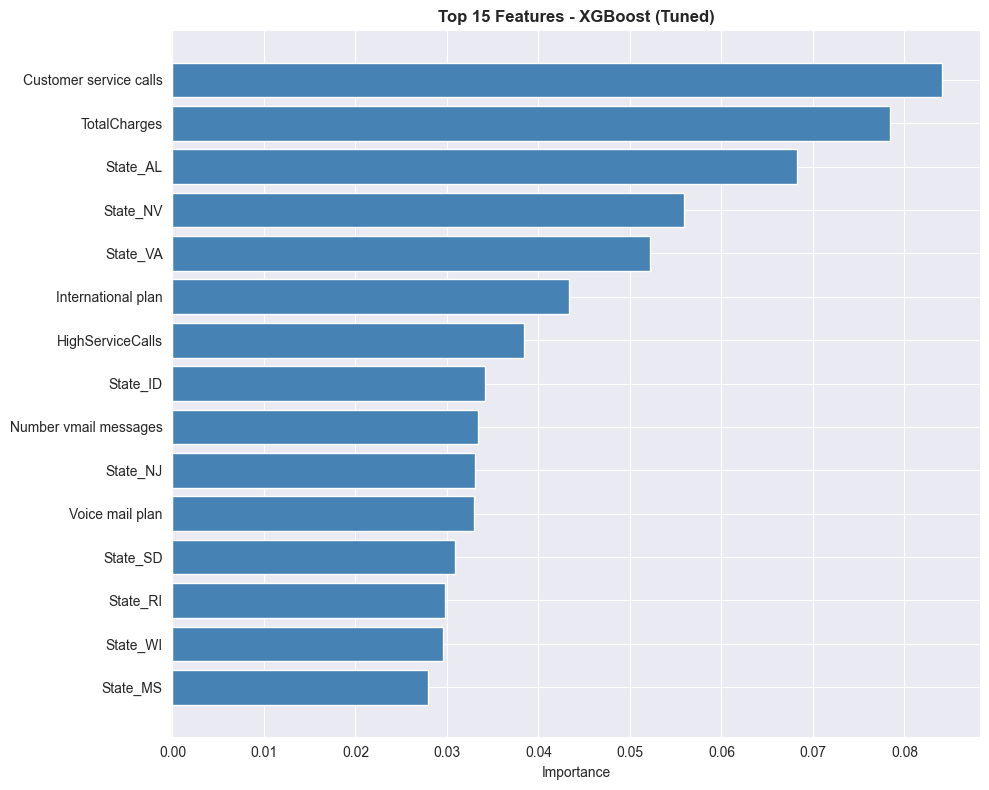

In [22]:
best_model = tuned_models[best_model_name]
importance_df = get_feature_importance(best_model, feature_names, best_model_name)

if importance_df is not None:
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)

    plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('telecom/feature_importance_telecom.png', dpi=300, bbox_inches='tight')
    plt.show()

## 11. Confusion Matrix Visualization

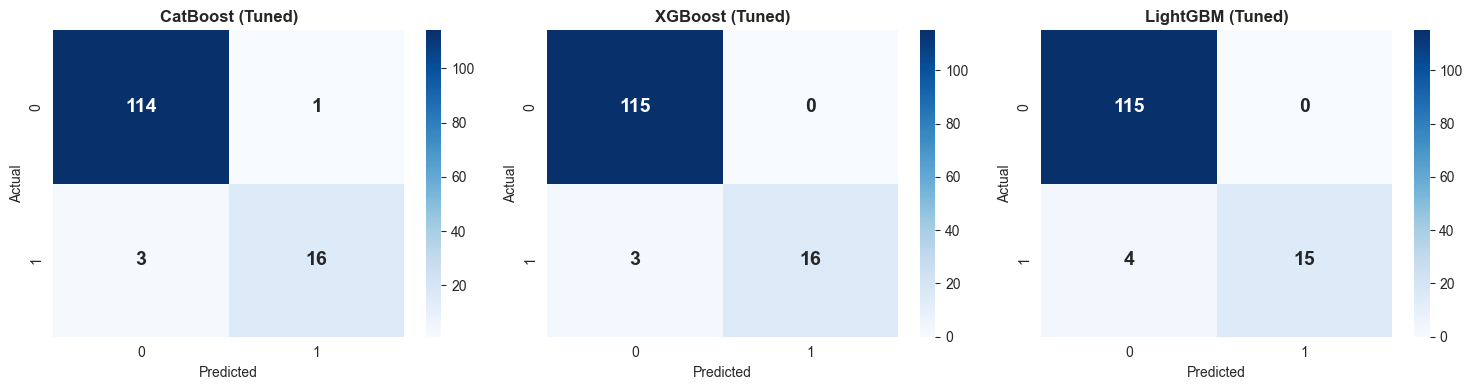

In [23]:
fig, axes = plt.subplots(1, len(tuned_models), figsize=(5 * len(tuned_models), 4))
if len(tuned_models) == 1:
    axes = [axes]

for idx, (name, model) in enumerate(tuned_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    axes[idx].set_title(f'{name}', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('telecom/confusion_matrices_telecom.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Conclusions

In [24]:
print('=' * 70)
print('FINAL SUMMARY')
print('=' * 70)

print('\n1. BEST MODEL:')
print(f'   {best_model_name}')
print(f'   F1-Score: {best_f1:.4f}')
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

print('\n2. ALL MODELS:')
print(results_df.to_string(index=False))

print('\n3. STATISTICAL SIGNIFICANCE:')
if n_bonferroni > 0:
    print(f'   {n_bonferroni} significant difference(s) found')
else:
    print('   No significant differences - models perform comparably')

print('\n4. TOP 5 FEATURES:')
if importance_df is not None:
    for idx, row in importance_df.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

print('\n' + '=' * 70)

FINAL SUMMARY

1. BEST MODEL:
   XGBoost (Tuned)
   F1-Score: 0.9143
   Accuracy: 0.9776

2. ALL MODELS:
           Model  Accuracy  Precision   Recall  F1-Score
 XGBoost (Tuned)  0.977612   1.000000 0.842105  0.914286
CatBoost (Tuned)  0.970149   0.941176 0.842105  0.888889
LightGBM (Tuned)  0.970149   1.000000 0.789474  0.882353

3. STATISTICAL SIGNIFICANCE:
   No significant differences - models perform comparably

4. TOP 5 FEATURES:
   Customer service calls: 0.0841
   TotalCharges: 0.0784
   State_AL: 0.0683
   State_NV: 0.0559
   State_VA: 0.0522

